# Generating dataset
---
---

# Imports

#### Standard library imports

In [2]:
import sys
import pickle
import os

sys.path.append("../../")

#### Third party imports

In [286]:
import pandas as pd
pd.set_option('display.max_columns', 500)

import numpy as np
import seaborn as sns
from scipy.stats import chi2

#### Local application imports

In [4]:
%load_ext autoreload
%autoreload 2

from pkg_dir.config import *
from pkg_dir.src.utils import *
from pkg_dir.src.functions import *
from pkg_dir.src.parameters import *

# Base dataset with no metadata

### Query on database

In [ ]:
## Function parameters
db_crds = 'pc_db_prod'
query = '''
SELECT cita.citaid as appointment_id,
       citafecha as appointment_date,
       citahorad as appointment_start_time,
       citahorah as appointment_end_time,
       citaestado as appointment_status,
       citasubsecuente as recurring_patient,
       u.usuarionomfull as doctor,
       e.especialidadnom as medical_specialty,
       su.sucursalnom as clinic,
       se.servicionom as service,
       p.pacienteid as patient_id,
       p.pacientesexo as patient_sex,
       p.pacientefnac as patient_birth_date

FROM cita

 INNER JOIN usuario u ON cita.citadoctorid = u.usuarioid
 INNER JOIN servicio se ON cita.servicioid = se.servicioid
 INNER JOIN especialidad e ON u.usuarioespecialidadid = e.especialidadid
 INNER JOIN sucursal su ON cita.citasucursalid = su.sucursalid
 LEFT JOIN paciente p ON cita.pacienteid = p.pacienteid

WHERE citafecha >= '2022-01-01'
  AND citafecha <= '2023-12-31'

;
'''


In [ ]:
dfx = sql_string_to_df(db_crds, query)
dfx.columns = [
    'appointment_id', 
    'appointment_date', 
    'appointment_start_time', 
    'appointment_end_time', 
    'appointment_status', 
    'recurring_patient', 
    'doctor', 
    'medical_specialty', 
    'clinic', 
    'service', 
    'patient_id', 
    'patient_sex', 
    'patient_birth_date'
]

### Formatting date columns

In [ ]:
## Formatting appointment dates
dfx['appointment_start'] = dfx['appointment_date'].astype('str') + ' ' + dfx['appointment_start_time']
dfx['appointment_start'] = pd.to_datetime(dfx['appointment_start'], format='%Y-%m-%d %H:%M')

dfx['appointment_end'] = dfx['appointment_date'].astype('str') + ' ' + dfx['appointment_end_time']
dfx['appointment_end'] = pd.to_datetime(dfx['appointment_end'], format='%Y-%m-%d %H:%M', errors='coerce')

In [ ]:
dfx = dfx[~dfx['appointment_end'].isna()].copy()

In [ ]:
## Appointment weekday
dfx['appointment_weekday'] = dfx['appointment_start'].dt.weekday

In [ ]:
## Appointment duration
dfx['appointment_dur_min'] = dfx['appointment_end'] - dfx['appointment_start']
dfx['appointment_dur_min'] = dfx['appointment_dur_min'].dt.total_seconds() / 60

### Age of patients

In [ ]:
## Numerical age
dfx['patient_age'] = dfx['patient_birth_date'].fillna('2025')
dfx['patient_age'] = dfx['patient_age'].apply(lambda x: str(x)[:4])
dfx['patient_age'] = 2024 - dfx['patient_age'].astype('float')
dfx['patient_age'] = dfx['patient_age'].apply(lambda x: np.nan if (x <= 0 or x >=110) else x)

### Patient sex clean up

In [ ]:
dfx['patient_sex'] = dfx['patient_sex'].replace({' ': None})

In [ ]:
dfx['patient_sex2'].unique()

### Recurring patient field

In [ ]:
dfx['recurring_patient'] = dfx['recurring_patient'].replace({' ': None})

In [ ]:
dfx['recurring_patient'] = dfx['recurring_patient'].map(
    {
        'P': 'first',
        'S': 'recurrent',
    }
)

In [ ]:
dfx['recurring_patient'].unique()

### Appointment status simplification

In [ ]:
## Reference to simplify labels in appointment status
values_map = {

    ## Completed
    'COMPLETADA': 'completed',
    'SALA_ESPERA': 'completed',
    'CONSULTA': 'completed',
    'CONFIRMADO_PAGO': 'completed',

    ## No shows
    'NO_PRESENTO': 'no_show',
    'MENSAJE_DEJADO': 'no_show',
    'NO_CONFIRMADO': 'no_show',
    'CONFIRMADO': 'no_show',
    'LLEGA_TARDE_ESPERA': 'no_show',
    'REAGENDAR': 'no_show',
    'TRIAGE': 'no_show',
    'TRIAGE_COMPLETO': 'no_show',
    'LISTA_ESPERA': 'no_show',
    'VALIDA_DATOS': 'no_show',

    ## Unused
    'DISPONIBLE': 'unused',

    ## Blocked
    'BLOQUEADO': 'blocked',

    ## Canceled
    'CANCELA_PACIENTE': 'cancel_patient',
    'CANCELA_EMPLEADO': 'cancel_employee',
    
    
}

In [ ]:
## Mapping values according to reference
dfx['appointment_status_simplified'] = dfx['appointment_status'].map(values_map).fillna(dfx['appointment_status'])

### Formatting data

In [ ]:
dfx.columns.tolist()

In [ ]:
## Reordering columns
rc = [
 ## Appointment features
 'appointment_id',
 'appointment_weekday',
 'appointment_start',
 'appointment_end',
 'appointment_dur_min',
 'recurring_patient',
 'appointment_status_simplified',
 'clinic',
 ## Patient info
 'patient_age',
 'patient_sex',
 ## Medical info
 'doctor',
 'medical_specialty',
]

In [ ]:
dfx = dfx.loc[:, rc].copy()

### Saving/loading data

In [ ]:
## Saving df as pickle and storing it locally
path = '../../pkg_dir/data/pickles/robs'
name = 'appts_extract.pkl'

pickle.dump(
    dfx,
    open(
        os.path.join(path, name),
        'wb'
    )
)

In [8]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'appts_extract.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [ ]:
## Saving as csv
dataset.to_csv('../../pkg_dir/data/pickles/robs/dataset.csv')

# Metadata actions

### Extracting from SQL

In [ ]:
sql_string = """
SELECT cita.citaid as appointment_id,
       c.cestatusobs as metadata,
       SUBSTRING(c.cestatusobs, '^[^ ]*') as metadata_usr,
       SUBSTRING(c.cestatusobs, '\((.+?)\)') as metadata_datetime,
       SUBSTRING(c.cestatusobs, ' :(.*?)  ') as metadata_action,
       SUBSTRING(c.cestatusobs, ' :(.*)') as metadata_action_full

FROM cita

 INNER JOIN citaestatus c ON cita.citaid = c.citaid AND cita.citaanio = c.citaanio


WHERE citafecha >= '2022-01-01'
  AND citafecha <= '2023-12-31'

;
"""

In [ ]:
dfx = sql_string_to_df('pc_db_prod', sql_string)

In [ ]:
dfx

In [ ]:
dfx.rename(
    columns={
        0: "appointment_id",
        1: "metadata_full",
        2: "user",
        3: "date",
        4: "action",
        5: "action_full",
    }, 
    inplace=True
)

### Pickle save/load

In [ ]:
## Saving df as pickle and storing it locally
path = '../../pkg_dir/data/pickles/robs'
name = 'metadata_raw.pkl'

pickle.dump(
    dfx,
    open(
        os.path.join(path, name),
        'wb'
    )
)

In [ ]:
## Saving df as pickle and storing it locally
path = '../../pkg_dir/data/pickles/robs'
name = 'metadata_raw.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfm = pickle.load(obj_content)

### Cleaning actions fields

In [ ]:
dfz = dfm.copy()

In [ ]:
## Dummy col
dfz['action_clean'] = 'irrelevant'

In [ ]:
### Confirmado
mr1 = dfz['action_full'].str.contains('Confirmado')

dfz.loc[mr1, 'action_clean'] = 'confirmed'

In [ ]:
### Creado
mr1 = dfz['action_full'].str.contains('Creado')

dfz.loc[mr1, 'action_clean'] = 'created'

In [ ]:
### No confirmado
mr1 = dfz['action_full'].str.contains('No confirmado')

dfz.loc[mr1, 'action_clean'] = 'not_confirmed'

In [ ]:
### Sala espera
mr1 = dfz['action_full'].str.contains('En sala de espera')

dfz.loc[mr1, 'action_clean'] = 'in_waiting_room'

In [ ]:
### Completado
mr1 = dfz['action_full'].str.contains('Completado')
mr2 = dfz['action_full'].str.contains('Completada')
mrs = mr1 | mr2

dfz.loc[mrs, 'action_clean'] = 'completed'

In [ ]:
### En consulta
mr1 = dfz['action_full'].str.contains('En consulta')

dfz.loc[mr1, 'action_clean'] = 'with_doctor'

In [ ]:
### No se presentó
mr1 = dfz['action_full'].str.contains('No se presentó')

dfz.loc[mr1, 'action_clean'] = 'no_show'

In [ ]:
### Cancelada por el paciente
mr1 = dfz['action_full'].str.contains('Cancelada por el paciente')

dfz.loc[mr1, 'action_clean'] = 'canceled_by_patient'

In [ ]:
### Cancelada por empledo
mr1 = dfz['action_full'].str.contains('Cancelada por empledo')

dfz.loc[mr1, 'action_clean'] = 'canceled_by_employee'

In [ ]:
### Se actualiza la fecha/hora
mr1 = dfz['action_full'].str.contains('Se actualiza la fecha/hora')

dfz.loc[mr1, 'action_clean'] = 'update_date_hour'

In [ ]:
### Disponible
mr1 = dfz['action_full'].str.contains('Disponible')

dfz.loc[mr1, 'action_clean'] = 'available'

In [ ]:
### Mensaje dejado
mr1 = dfz['action_full'].str.contains('Mensaje dejado')

dfz.loc[mr1, 'action_clean'] = 'message_left'

### Formatting and adjusting

In [ ]:
dfz[dfz['action_clean'] == 'completed']

In [ ]:
## Dropping irrelevant columns
mr1 = dfz['action_clean'] != 'irrelevant'
rc = ['appointment_id', 'user', 'date', 'action_clean']

dfz = dfz.loc[mr1, rc].copy()

In [ ]:
## Adjusting dateformat
dfz['date'] = pd.to_datetime(dfz['date'], format='%d/%m/%Y %H:%M:%S', errors='coerce')

dfz = dfz.loc[~dfz['date'].isna(), :].copy()

In [ ]:
## Sorting values 
dfz.sort_values(by=['appointment_id', 'action_clean', 'date'], inplace=True, ascending=False)

In [ ]:
## Keeping latest 
dfz.drop_duplicates(keep='first', subset=['appointment_id', 'action_clean'], inplace=True)

### Pivot

In [ ]:
dfp = dfz.pivot(index='appointment_id', columns='action_clean', values=['user', 'date'])

In [ ]:
dfp.columns = ['meta__' + col[1] + '_$' + col[0] for col in dfp.columns]

In [ ]:
cols = dfp.columns.tolist()
cols.sort()

dfp = dfp.loc[:, cols].copy()

### Pickle save/load

In [ ]:
## Saving df as pickle and storing it locally
path = '../../pkg_dir/data/pickles/robs'
name = 'pivot_df_v2.pkl'

pickle.dump(
    dfp,
    open(
        os.path.join(path, name),
        'wb'
    )
)

In [4]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'pivot_df_v2.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfp = pickle.load(obj_content)

# Merging metadata + new features

### Merging

In [6]:
dfp.reset_index(inplace = True)

In [10]:
dataset = pd.merge(dfx, dfp, on='appointment_id', how='left')

### Creation to appointment start

In [12]:
## Appointment duration
dataset['creation_to_start_hrs'] = dataset['appointment_start'] - dataset['meta__created_$date']
dataset['creation_to_start_hrs'] = dataset['creation_to_start_hrs'].dt.total_seconds() / (60*60)
dataset['creation_to_start_hrs'] = dataset['creation_to_start_hrs'].round(2)

### Confirmation to appointment start

In [13]:
## Appointment duration
dataset['confirm_to_start_hrs'] = dataset['appointment_start'] - dataset['meta__confirmed_$date']
dataset['confirm_to_start_hrs'] = dataset['confirm_to_start_hrs'].dt.total_seconds() / (60*60)
dataset['confirm_to_start_hrs'] = dataset['confirm_to_start_hrs'].round(2)

In [14]:
## Confirmation tag
dataset['patient_confirm'] = 0
dataset.loc[dataset['confirm_to_start_hrs'].notnull(), 'patient_confirm'] = 1

### Cancel employee to appointment start

In [15]:
dataset['cancelemp_to_start_hrs'] = dataset['appointment_start'] - dataset['meta__canceled_by_employee_$date']
dataset['cancelemp_to_start_hrs'] = dataset['cancelemp_to_start_hrs'].dt.total_seconds() / (60*60)
dataset['cancelemp_to_start_hrs'] = dataset['cancelemp_to_start_hrs'].round(2)

### Cancel patient to appointment start

In [16]:
dataset['cancelpat_to_start_hrs'] = dataset['appointment_start'] - dataset['meta__canceled_by_patient_$date']
dataset['cancelpat_to_start_hrs'] = dataset['cancelpat_to_start_hrs'].dt.total_seconds() / (60*60)
dataset['cancelpat_to_start_hrs'] = dataset['cancelpat_to_start_hrs'].round(2)

### Unifying cancels

In [17]:
dataset['cancel_to_start_hrs'] = dataset['cancelemp_to_start_hrs']
dataset.loc[dataset['cancelpat_to_start_hrs'].notnull(), 'cancel_to_start_hrs'] = dataset.loc[dataset['cancelpat_to_start_hrs'].notnull(), 'cancelpat_to_start_hrs']

### Source of appointment

In [18]:
## Appointment duration
dataset['appointment_source'] = dataset['meta__created_$user'].apply(lambda x: 'online' if x == 'citas.online' else 'phone')

### Appointment moved

In [19]:
## Appointment duration
dataset['appointment_date_update'] = 'no_update'
dataset.loc[dataset['meta__update_date_hour_$user'].notnull(), 'appointment_date_update'] = 'update'

### Confirmation message sent

In [20]:
## message for confirmation
dataset['confirm_request_msg'] = 0
dataset.loc[dataset['meta__message_left_$user'].notnull(), 'confirm_request_msg'] = 1

In [21]:
dataset['confirm_request_msg'].value_counts()

confirm_request_msg
0    498388
1     45700
Name: count, dtype: int64

### Select relevant columns

In [22]:
dataset.columns.tolist()

['appointment_id',
 'appointment_weekday',
 'appointment_start',
 'appointment_end',
 'appointment_dur_min',
 'recurring_patient',
 'appointment_status_simplified',
 'clinic',
 'patient_age',
 'patient_sex',
 'doctor',
 'medical_specialty',
 'meta__available_$date',
 'meta__available_$user',
 'meta__canceled_by_employee_$date',
 'meta__canceled_by_employee_$user',
 'meta__canceled_by_patient_$date',
 'meta__canceled_by_patient_$user',
 'meta__completed_$date',
 'meta__completed_$user',
 'meta__confirmed_$date',
 'meta__confirmed_$user',
 'meta__created_$date',
 'meta__created_$user',
 'meta__in_waiting_room_$date',
 'meta__in_waiting_room_$user',
 'meta__message_left_$date',
 'meta__message_left_$user',
 'meta__no_show_$date',
 'meta__no_show_$user',
 'meta__update_date_hour_$date',
 'meta__update_date_hour_$user',
 'meta__with_doctor_$date',
 'meta__with_doctor_$user',
 'creation_to_start_hrs',
 'confirm_to_start_hrs',
 'patient_confirm',
 'cancelemp_to_start_hrs',
 'cancelpat_to_star

In [24]:
## Reordering columns
rc = [
 ## Appointment features
 'appointment_id',
 'appointment_weekday',
 'appointment_start',
 'appointment_dur_min',
 'recurring_patient',
 'creation_to_start_hrs',
 'confirm_request_msg',
 'patient_confirm',
 'cancel_to_start_hrs',
 'confirm_to_start_hrs',
 'clinic',
 'appointment_source',
 'appointment_date_update',
 ## Patient info
 'patient_age',
 'patient_sex',
 ## Medical info
 'doctor',
 'medical_specialty',
 ## Label
 'appointment_status_simplified',
]

In [25]:
dataset = dataset.loc[:, rc].copy()

---
# Patient history

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'appts_extract.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

### Relevant data

In [ ]:
dfx['appointment_status_simplified'].unique()

In [ ]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'completed',
        'no_show'
    ]
)
mr2 = dfx['patient_id'].notnull()
mrs = mr1 & mr2

rc = [
    'appointment_id',
    'patient_id',
    'appointment_status_simplified',
]

### Grouping

In [ ]:
dfx

---
# Final dataset

In [27]:
## Saving df as pickle and storing it locally
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'

pickle.dump(
    dataset,
    open(
        os.path.join(path, name),
        'wb'
    )
)

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dataset = pickle.load(obj_content)

In [ ]:
dataset['appointment_date_update'].value_counts()

In [ ]:
dataset['appointment_status_simplified'].value_counts()

In [ ]:
dataset['appointment_dur_min'].value_counts()

---
# Subdatasets

### v1: 
    - completed, cancel and no_shows

#### Creating dataset

In [ ]:
mr1 = dataset['appointment_status_simplified'].isin(
    [
        'cancel_employee',
        'cancel_patient',
        'completed',
        'no_show',
    ]
)

mrs = mr1

dv1 = dataset.loc[mrs, :].copy()

In [ ]:
dv1['appointment_status_simplified'] = dv1['appointment_status_simplified'].map(
    {
        'cancel_employee': 'cancel',
        'cancel_patient': 'cancel',
    }
).fillna(dv1['appointment_status_simplified'])

In [ ]:
dv1.shape

#### Saving

In [ ]:
## Saving df as pickle and storing it locally
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset_v1.pkl'

pickle.dump(
    dv1,
    open(
        os.path.join(path, name),
        'wb'
    )
)

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset_v1.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dv1 = pickle.load(obj_content)

#### Multicollinearity

### v2: 
    - confirmed only
    - completed, cancel and no_shows

In [ ]:
mr1 = dataset['patient_confirm'] == 1
mr2 = dataset['appointment_status_simplified'].isin(
    [
        'cancel_employee',
        'cancel_patient',
        'completed',
        'no_show',
    ]
)

mrs = mr1 & mr2

dv2 = dataset.loc[mrs, :].copy()

In [ ]:
dv2['appointment_status_simplified'] = dv2['appointment_status_simplified'].map(
    {
        'cancel_employee': 'cancel',
        'cancel_patient': 'cancel',
    }
).fillna(dv2['appointment_status_simplified'])

In [ ]:
## Saving df as pickle and storing it locally
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset_v2.pkl'

pickle.dump(
    dv2,
    open(
        os.path.join(path, name),
        'wb'
    )
)

name = 'dataset_v2.csv'
dv2.to_csv(os.path.join(path, name))

In [ ]:
dv2.shape

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset_v2.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dv2 = pickle.load(obj_content)

### v3: 
    - confirmed only
    - completed, cancel and no_shows
    - only top specialties ('ENDOCRINOLOGIA', 'DERMATOLOGIA', 'GINECOLOGIA', 'GASTROENTEROLOGIA', 'UROLOGIA', 'OTORRINOLARINGOLOGIA’)

In [ ]:
mr1 = dataset['patient_confirm'] == 1
mr2 = dataset['appointment_status_simplified'].isin(
    [
        'cancel_employee',
        'cancel_patient',
        'completed',
        'no_show',
    ]
)
mr3 = dataset['medical_specialty'].isin(
    [
        'DERMATOLOGIA',
        'GINECOLOGIA',
        'OTORRINOLARINGOLOGIA',
        'UROLOGIA',
        'GASTROENTEROLOGIA',
        'ENDOCRINOLOGIA',
    ]
)

mrs = mr1 & mr2 & mr3

dv3 = dataset.loc[mrs, :].copy()

In [ ]:
dv3['appointment_status_simplified'] = dv3['appointment_status_simplified'].map(
    {
        'cancel_employee': 'cancel',
        'cancel_patient': 'cancel',
    }
).fillna(dv3['appointment_status_simplified'])

In [ ]:
## Saving df as pickle and storing it locally
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset_v3.pkl'

pickle.dump(
    dv3,
    open(
        os.path.join(path, name),
        'wb'
    )
)

name = 'dataset_v3.csv'
dv3.to_csv(os.path.join(path, name))

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset_v3.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dv3 = pickle.load(obj_content)

### v4: 
    - confirmed only
    - completed, cancel and no_shows
    - Only Basilica
    - only top Basilica specialties ('DERMATOLOGIA', 'GINECOLOGIA', 'UROLOGIA', 'OTORRINOLARINGOLOGIA')

In [ ]:
mr1 = dataset['patient_confirm'] == 1
mr2 = dataset['appointment_status_simplified'].isin(
    [
        'cancel_employee',
        'cancel_patient',
        'completed',
        'no_show',
    ]
)
mr3 = dataset['medical_specialty'].isin(
    [
        'DERMATOLOGIA',
        'GINECOLOGIA',
        'UROLOGIA',
        'OTORRINOLARINGOLOGIA',
    ]
)
mr4 = dataset['clinic'].isin(
    [
        'BASILICA',
    ]
)

mrs = mr1 & mr2 & mr3 & mr4

dv4 = dataset.loc[mrs, :].copy()

In [ ]:
dv4['appointment_status_simplified'] = dv4['appointment_status_simplified'].map(
    {
        'cancel_employee': 'cancel',
        'cancel_patient': 'cancel',
    }
).fillna(dv4['appointment_status_simplified'])

In [ ]:
## Saving df as pickle and storing it locally
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset_v4.pkl'

pickle.dump(
    dv4,
    open(
        os.path.join(path, name),
        'wb'
    )
)

name = 'dataset_v4.csv'
dv4.to_csv(os.path.join(path, name))

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset_v4.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dv4 = pickle.load(obj_content)

In [ ]:
dv4.shape

In [ ]:
dv4.

In [ ]:
dv4.groupby(
    [
        'patient_confirm',
        'appointment_status_simplified',
    ]
).agg(
    {
        'appointment_id': 'count'
    }
)

### v5 
    - Successful (completed), and failed appointments (no-show + short-cancel)
    - Remove appointments canceled with more than 24 hours of anticipation

In [48]:
mr1 = dataset['appointment_status_simplified'].isin(
    [
        'cancel_employee',
        'cancel_patient',
        'completed',
        'no_show',
    ]
)

mr2 = (dataset['cancel_to_start_hrs'] <= 24) | (dataset['cancel_to_start_hrs'].isnull())

mrs = mr1 & mr2

dv5 = dataset.loc[mrs, :].copy()
dv5.drop('cancel_to_start_hrs', axis=1, inplace=True)

In [49]:
dv5['appointment_status_simplified'] = dv5['appointment_status_simplified'].map(
    {
        'no_show': 'fail',
        'cancel_employee': 'fail',
        'cancel_patient': 'fail',
    }
).fillna(dv5['appointment_status_simplified'])

In [51]:
## Saving df as pickle and storing it locally
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset_v5.pkl'

pickle.dump(
    dv5,
    open(
        os.path.join(path, name),
        'wb'
    )
)

name = 'dataset_v5.csv'
dv5.to_csv(os.path.join(path, name))

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset_v5.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dv5 = pickle.load(obj_content)

### v6 
    - Successful (completed), and failed appointments (no-show + short-cancel)
    - Remove appointments canceled with more than 24 hours of anticipation
    - only top specialties ('ENDOCRINOLOGIA', 'DERMATOLOGIA', 'GINECOLOGIA', 'GASTROENTEROLOGIA', 'UROLOGIA', 'OTORRINOLARINGOLOGIA’)

In [54]:
mr1 = dataset['appointment_status_simplified'].isin(
    [
        'cancel_employee',
        'cancel_patient',
        'completed',
        'no_show',
    ]
)
mr2 = (dataset['cancel_to_start_hrs'] <= 24) | (dataset['cancel_to_start_hrs'].isnull())
mr3 = dataset['medical_specialty'].isin(
    [
        'DERMATOLOGIA',
        'GINECOLOGIA',
        'OTORRINOLARINGOLOGIA',
        'UROLOGIA',
        'GASTROENTEROLOGIA',
        'ENDOCRINOLOGIA',
    ]
)

mrs = mr1 & mr2 & mr3

dv6 = dataset.loc[mrs, :].copy()
dv6.drop('cancel_to_start_hrs', axis=1, inplace=True)

In [55]:
dv6['appointment_status_simplified'] = dv6['appointment_status_simplified'].map(
    {
        'no_show': 'fail',
        'cancel_employee': 'fail',
        'cancel_patient': 'fail',
    }
).fillna(dv6['appointment_status_simplified'])

In [56]:
## Saving df as pickle and storing it locally
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset_v6.pkl'

pickle.dump(
    dv6,
    open(
        os.path.join(path, name),
        'wb'
    )
)

name = 'dataset_v6.csv'
dv6.to_csv(os.path.join(path, name))

In [ ]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset_v6.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dv6 = pickle.load(obj_content)

In [58]:
dv6.shape

(237229, 17)

---
# Dataset grouped by specialty/clinic

In [104]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [105]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
mr2 = dfx['appointment_start'].dt.weekday < 5 ## only weekdays
mr3 = dfx['clinic'] == 'BASILICA'
mr4 = dfx['medical_specialty'] == 'DERMATOLOGIA'
# mr4 = dfx['doctor'] == 'DRA BERTHA LUCIA PEREZ RIOS'
mrs = mr1 & mr2 & mr3 & mr4

rc = [
    'appointment_id',
    'appointment_start',
    'clinic',
    'doctor',
    'medical_specialty',
    'appointment_status_simplified',
]

In [106]:
dfy = dfx.loc[mrs, rc].copy()

In [107]:
## New columns
dfy['appointment_hr'] = dfy['appointment_start'].dt.hour
dfy['appointment_date'] = dfy['appointment_start'].dt.date
dfy['new_is'] = dfy['clinic'].str[0:2] + '|' + dfy['medical_specialty'].str[0:4] + '|' + dfy['appointment_start'].dt.date.astype(str) + '|' + dfy['appointment_hr'].astype(str)

##### Appointment status

In [108]:
dfy2 = dfy.groupby(
    [
        'new_is',
        'appointment_status_simplified', 
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

In [109]:
dfy2 = dfy2.pivot(
    index=['new_is'], 
    columns=['appointment_status_simplified'], 
    values=['appointment_id'], 
).reset_index()

dfy2.columns = [
    col[1] 
    if col[0] == 'appointment_id'
    else col[0]
    for col in dfy2.columns
]

dfy2.fillna(0, inplace=True)

In [72]:
dfy2[dfy2['new_is'].str.contains('2023-08-14')]

,new_is,completed,no_show,unused
5056,BA|DERM|2023-08-14|10,2.0,2.0,0.0
5057,BA|DERM|2023-08-14|11,4.0,0.0,0.0
5058,BA|DERM|2023-08-14|12,4.0,0.0,0.0
5059,BA|DERM|2023-08-14|13,2.0,2.0,0.0
5060,BA|DERM|2023-08-14|14,2.0,0.0,0.0
5061,BA|DERM|2023-08-14|15,2.0,0.0,0.0
5062,BA|DERM|2023-08-14|16,2.0,0.0,0.0
5063,BA|DERM|2023-08-14|17,1.0,1.0,0.0
5064,BA|DERM|2023-08-14|18,2.0,0.0,0.0
5065,BA|DERM|2023-08-14|19,2.0,0.0,0.0


##### Doctors

In [114]:
dfy3 = dfy.groupby(
    [
        'new_is',
        'appointment_date',
        'appointment_hr',
    ],
    as_index=False
).agg(
    {
        # 'doctor': ['nunique', 'unique'],
        'doctor': 'nunique',
    }
)

# dfy3.columns = [
#     col[0] 
#     if col[1] == ''
#     else col[0] + '_' + col[1]
#     for col in dfy3.columns
# ]

In [81]:
dfy3[dfy3['new_is'].str.contains('2023-08-14')]

,new_is,doctor_nunique,doctor_unique
5056,BA|DERM|2023-08-14|10,2,"[DRA Maura Robledo Cayetano, DRA SANDRA GEOR..."
5057,BA|DERM|2023-08-14|11,2,"[DRA Maura Robledo Cayetano, DRA SANDRA GEOR..."
5058,BA|DERM|2023-08-14|12,2,"[DRA SANDRA GEORGINA RUELAS GONZALEZ, DRA Maur..."
5059,BA|DERM|2023-08-14|13,2,"[DRA Maura Robledo Cayetano, DRA SANDRA GEOR..."
5060,BA|DERM|2023-08-14|14,2,"[DRA SANDRA GEORGINA RUELAS GONZALEZ, DRA BERT..."
5061,BA|DERM|2023-08-14|15,1,[DRA BERTHA LUCIA PEREZ RIOS]
5062,BA|DERM|2023-08-14|16,1,[DRA BERTHA LUCIA PEREZ RIOS]
5063,BA|DERM|2023-08-14|17,1,[DRA BERTHA LUCIA PEREZ RIOS]
5064,BA|DERM|2023-08-14|18,1,[DRA BERTHA LUCIA PEREZ RIOS]
5065,BA|DERM|2023-08-14|19,1,[DRA BERTHA LUCIA PEREZ RIOS]


##### Merging appointment status and doctors

In [125]:
dfy = pd.merge(
    left=dfy3,
    right=dfy2,
    how='inner',
    on='new_is'
)

In [126]:
dfy['used'] = dfy['completed'] + dfy['no_show']
dfy['total'] = dfy['used'] + dfy['unused']
dfy['occup_ratio'] = dfy['used']/dfy['total']
dfy['occup_ratio_bool'] = dfy['occup_ratio'].apply(lambda x: 1 if x == 1 else 0)

In [136]:
dfy.groupby(
    [
        'appointment_hr',
    ],
    as_index=False
).agg(
    {
        'total': ['min', 'max', 'mean'],
        'occup_ratio': 'mean',
        'occup_ratio_bool': 'mean',
        'doctor': ['min', 'max', 'mean'],
    }
)

appointment_hr total                 occup_ratio occup_ratio_bool doctor  \
                    min   max      mean        mean             mean    min   
0               7   1.0   5.0  1.721649    0.829840         0.762887      1   
1               8   1.0   9.0  5.227799    0.821446         0.469112      1   
2               9   1.0   9.0  5.218147    0.838332         0.515444      1   
3              10   1.0   9.0  5.204239    0.858177         0.570328      1   
4              11   2.0   8.0  5.247582    0.864325         0.582205      1   
5              12   1.0  13.0  5.212766    0.870323         0.607350      1   
6              13   1.0   9.0  5.152510    0.881225         0.619691      1   
7              14   1.0   6.0  2.223433    0.946049         0.888283      1   
8              15   1.0   9.0  3.349901    0.869512         0.675944      1   
9              16   1.0   9.0  3.321285    0.871506         0.688755      1   
10             17   1.0   8.0  3.237425    0.889118         0.720322      1   
11             18   1.0   8.0  3.233871    0.879188         0.703629      1   
12             19   1.0   8.0  3.034553    0.865053         0.693089      1   
13             20   1.0   1.0  1.000000    1.000000         1.000000      1   

                  
   max      mean  
0    3  1.268041  
1    4  2.486486  
2    4  2.474903  
3    5  2.487476  
4    4  2.473888  
5    4  2.485493  
6    4  2.474903  
7    4  1.504087  
8    4  1.477137  
9    3  1.457831  
10   3  1.420523  
11   3  1.419355  
12   3  1.402439  
13   1  1.000000

In [120]:
dfy['doctor'].value_counts()

doctor
2    2396
1    2096
3    1740
4      22
5       1
Name: count, dtype: int64

In [98]:
dfy[dfy['doctor_nunique'] == 5]['doctor_unique'].values[0]

array(['DRA BERTHA LUCIA PEREZ RIOS', 'DRA ANA MARIA ESCOBEDO HERNANDEZ',
       'DR. JOSE LUIS SANCHEZ RODRIGUEZ', 'DRA Maura  Robledo  Cayetano',
       'DRA SANDRA GEORGINA RUELAS GONZALEZ'], dtype=object)

---
# Notes

### Histogram proposed by Candi (no-shows per session of consecutive)

In [347]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [348]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
mr2 = dfx['appointment_start'].dt.weekday < 5 ## only weekdays
mr3 = dfx['clinic'] == 'BASILICA'
mr4 = dfx['appointment_start'].dt.year == 2023 ## only weekdays
mr5 = dfx['medical_specialty'] == 'DERMATOLOGIA'
# mr4 = dfx['doctor'] == 'DRA BERTHA LUCIA PEREZ RIOS'
mrs = mr1 & mr2 & mr3 & mr4 & mr5

rc = [
    'appointment_id',
    'appointment_start',
    'clinic',
    'doctor',
    'medical_specialty',
    'appointment_status_simplified',
]

In [350]:
dfy = dfx.loc[mrs, rc].copy()

In [351]:
## New columns
dfy['appointment_hr'] = dfy['appointment_start'].dt.hour
dfy['appointment_date'] = dfy['appointment_start'].dt.date
dfy['new_is'] = dfy['clinic'].str[0:2] + '|' + dfy['medical_specialty'].str[0:4] + '|' + dfy['appointment_start'].dt.date.astype(str)

dfy['appt_completed'] = dfy['appointment_status_simplified'].apply(lambda x: 1 if x == 'completed' else 0)
dfy['appt_noshow'] = dfy['appointment_status_simplified'].apply(lambda x: 1 if x == 'no_show' else 0)

##### No-show distribution

In [390]:
dfy2 = dfy.groupby(
# dfy.groupby(
    [
        'medical_specialty',
        'clinic',
        'appointment_date',
        'doctor', 
    ],
    as_index=False
).agg(
    {
        # 'appointment_hr': ['max', 'min'],
        'appointment_id': 'count',
        'appt_completed': 'sum',
        'appt_noshow': 'sum',
    }
)

In [372]:
dfy2['appointment_id'].value_counts()

appointment_id
12    320
14    189
10    174
11    153
13     66
15     49
1      46
9      32
2      27
18     18
16      9
8       8
3       7
4       7
24      4
17      2
20      2
19      2
6       1
23      1
Name: count, dtype: int64

In [373]:
dfy2.loc[dfy2['appointment_id'] == 12, 'appt_noshow'].value_counts()

appt_noshow
2    91
1    86
3    55
0    46
4    28
5    11
6     3
Name: count, dtype: int64

In [392]:
dfy2 = dfy2.loc[dfy2['appointment_id'] == 12, :].copy()

In [375]:
np.mean(dfy2['appt_noshow']/(dfy2['appt_completed'] + dfy2['appt_noshow']))

0.17745468073593074

In [376]:
np.mean(dfy2['appt_noshow']/dfy2['appointment_id'])

0.1609375

<Axes: xlabel='appt_noshow', ylabel='Count'>

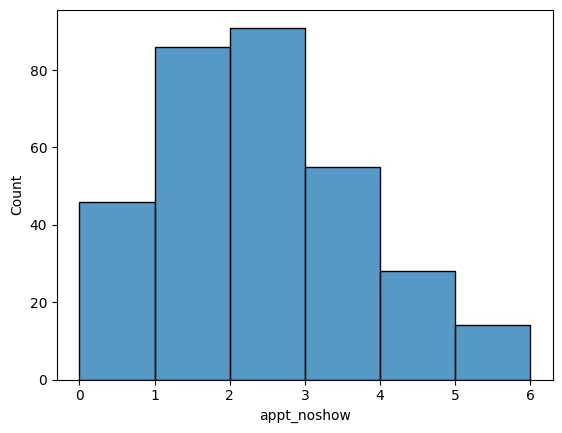

In [377]:
sns.histplot(
    data=dfy2, 
    x='appt_noshow', 
    binwidth=1
)

In [378]:
dfy2 = dfy2.groupby(['appt_noshow']).agg({'new_is': 'count'})

##### Binomial distribution

In [362]:
n = 320

In [363]:
dfbin = pd.DataFrame(
    np.linspace(1, n, n)
)

In [364]:
dfbin['bin'] = dfbin[0].apply(lambda x: x*0 + np.random.binomial(12, 0.161))

<Axes: xlabel='bin', ylabel='Count'>

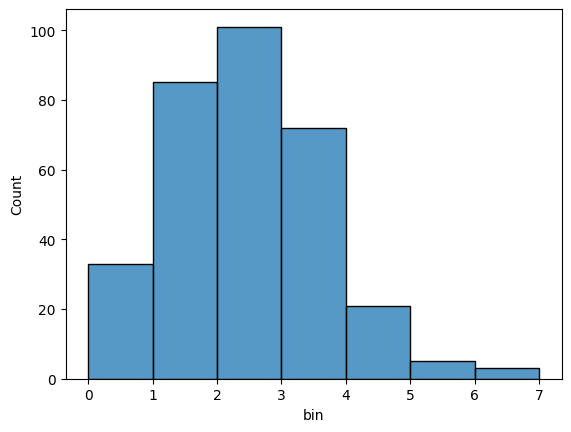

In [365]:
sns.histplot(data=dfbin, x='bin', binwidth=1)

In [366]:
dfbin = dfbin.groupby('bin').agg({0: 'count'})

##### Test difference

In [380]:
dfy2

,new_is
appt_noshow,
0,46
1,86
2,91
3,55
4,28
5,11
6,3


In [368]:
dfbin

,0
bin,
0.0,33
1.0,85
2.0,101
3.0,72
4.0,21
5.0,5
6.0,2
7.0,1


In [386]:
chi_sq = np.sum((dfy2['new_is'] - dfbin[0])**2/dfbin[0])
chi_sq

20.170298059217686

In [387]:
# chi2.ppf(0.95, df=1500)
chi2.ppf(0.95, df=dfy2.shape[0] - 1)

12.591587243743977

In [388]:
# p = 1 - chi2.cdf(chi_sq, df=dfy2.shape[0] - 1)
p = 1 - chi2.cdf(14, df=dfy2.shape[0] - 1)
p

0.029636163880521815

### Patients first time vs second

In [ ]:
dfx.groupby(
    [
        'recurring_patient'
    ]
).agg(
    {
        'appointment_id': 'count'
    }
)

### Confirmed patients

In [ ]:
dataset.groupby(
    [
        pd.Grouper(key='appointment_start', freq='Y'),
        'appointment_status_simplified',
        'patient_confirm',
    ]
).agg(
    {
        'appointment_id': 'count'
    }
)

In [ ]:
dataset.groupby(
    [
        'appointment_source',
        'appointment_status_simplified',
    ]
).agg(
    {
        'appointment_id': 'count'
    }
)

---

---